In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# new import statements
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

import numpy as np

### Lake Michigan Waves

Source: https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

In [2]:
df = pd.read_csv("waves.csv")
# Clean up
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Calumet Beach,04/07/2018 12:30:00 AM,21.7,3.15,NaN,0.389,3.0,0.0,04/07/2018 12:30 AM,CalumetBeach201804072430
1,Ohio Street Beach,06/14/2019 07:00:00 PM,16.0,2.18,NaN,0.137,3.0,11.8,06/14/2019 7:00 PM,OhioStreetBeach201906141900
2,Ohio Street Beach,05/16/2018 01:00:00 PM,21.7,1.92,NaN,0.023,1.0,10.3,05/16/2018 1:00 PM,OhioStreetBeach201805161300
3,Ohio Street Beach,05/16/2018 02:00:00 PM,21.9,1.81,NaN,0.026,6.0,10.3,05/16/2018 2:00 PM,OhioStreetBeach201805161400
4,Ohio Street Beach,06/04/2018 09:00:00 AM,23.0,0.03,NaN,0.021,8.0,12.4,06/04/2018 9:00 AM,OhioStreetBeach201806040900


In [3]:
train, test = train_test_split(df, random_state=320)
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
28817,Ohio Street Beach,07/04/2019 04:00:00 PM,21.5,0.94,NaN,0.137,4.0,11.8,07/04/2019 4:00 PM,OhioStreetBeach201907041600
13162,Calumet Beach,08/07/2016 04:00:00 PM,25.5,0.67,NaN,0.253,2.0,9.8,08/07/2016 4:00 PM,CalumetBeach201608071600
13110,Calumet Beach,08/05/2016 11:00:00 AM,24.1,1.03,NaN,0.173,3.0,10.1,08/05/2016 11:00 AM,CalumetBeach201608051100
23538,Ohio Street Beach,06/15/2015 08:00:00 AM,18.0,1.25,NaN,0.066,4.0,11.9,06/15/2015 8:00 AM,OhioStreetBeach201506150800
30642,Ohio Street Beach,07/29/2017 07:00:00 PM,23.4,3.80,NaN,0.187,3.0,11.5,07/29/2017 7:00 PM,OhioStreetBeach201707291900


In [4]:
ycol = "Wave Height"

## LinearRegression model review

- can only take a column of numbers and assign a weight to it (to multiply that column by that weight)
- how do we introduce polynomial features (PolynomialFeatures - last lecture) or catgeorical features?

### Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

#### Model 3: Beach Name (Categorical)

In [5]:
train["Beach Name"].unique()

array(['Ohio Street Beach', 'Calumet Beach', 'Rainbow Beach',
       'Osterman Beach', '63rd Street Beach', 'Montrose Beach'],
      dtype=object)

Naive way of assigning numerial values to a categorical column:
- `Ohio Street Beach`: 1
- `Calumet Beach`: 2
- `Rainbow Beach`: 3, etc.,
- Problem: `Calumet Beach` will become an average of `Ohio Street Beach` and `Rainbow Beach` => this doesn't make any sense!

#### `OneHotEncoder()`

- encodes categorical features as a one-hot numeric array
- returns a "sparse matrix", which needs to be explicitly converted into an `array` using `to_array()` method, before `DataFrame` conversion
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [6]:
xcols = ["Beach Name"]

In [7]:
oh = OneHotEncoder()
oh.fit_transform(train[xcols])

<29871x6 sparse matrix of type '<class 'numpy.float64'>'
	with 29871 stored elements in Compressed Sparse Row format>

In [8]:
oh.fit_transform(train[xcols])

<29871x6 sparse matrix of type '<class 'numpy.float64'>'
	with 29871 stored elements in Compressed Sparse Row format>

In [9]:
# All steps
oh = OneHotEncoder()
pd.DataFrame(oh.fit_transform(train[xcols]).toarray(), columns=oh.get_feature_names_out())

,Beach Name_63rd Street Beach,Beach Name_Calumet Beach,Beach Name_Montrose Beach,Beach Name_Ohio Street Beach,Beach Name_Osterman Beach,Beach Name_Rainbow Beach
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
29866,0.0,0.0,0.0,0.0,1.0,0.0
29867,0.0,0.0,0.0,1.0,0.0,0.0
29868,0.0,0.0,0.0,0.0,1.0,0.0
29869,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
m3

Pipeline(steps=[('oh', OneHotEncoder()), ('lr', LinearRegression())])

In [11]:
scores = cross_val_score(m3, train[xcols], train[ycol], cv=10)
scores.mean()

0.04564310407563701

**Conclusion:** mean R^2 score is slightly lower than 0.0489 (polynomial).

<div>
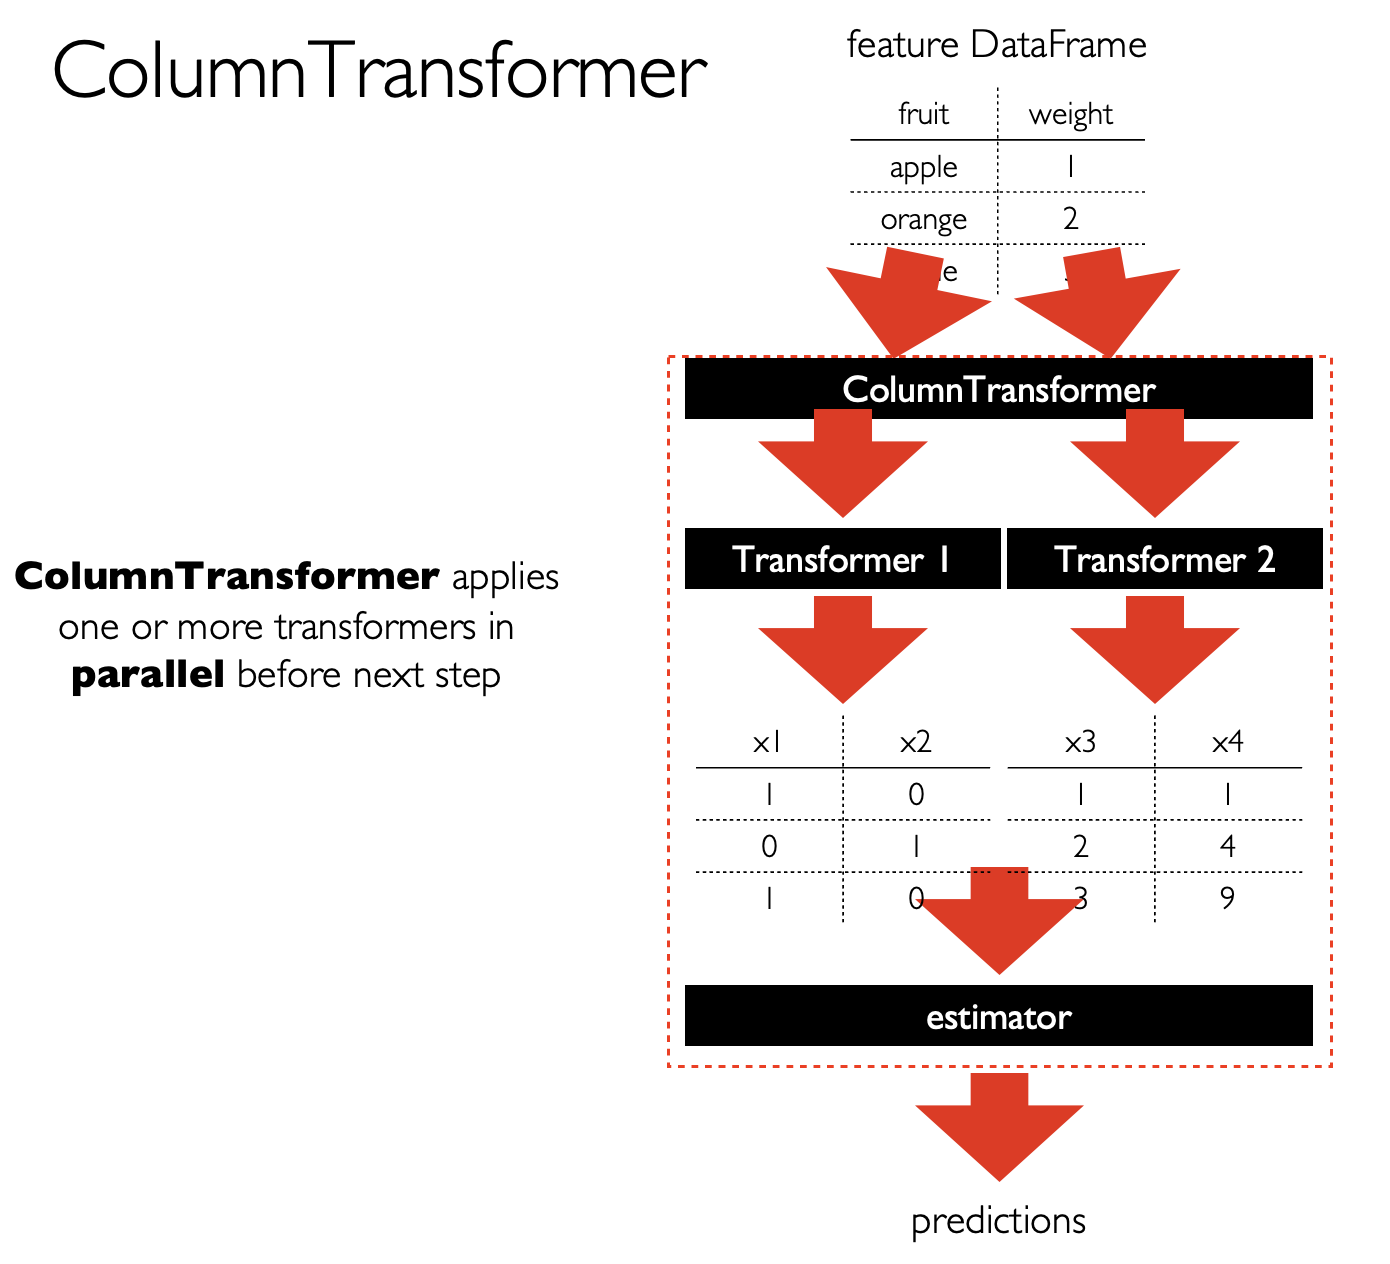
</div>

#### `make_column_transformer(...)`

- Argument: transformations
    - each transformer argument will be a `tuple` with object instance as first item and list of feature columns as the second
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

#### Model 4: Beach Name (Categorical) and Wave Period (Polynomial)

In [12]:
custom_trans = make_column_transformer(
    (PolynomialFeatures(), ["Wave Period"]),
    (OneHotEncoder(), ["Beach Name"]),
)
custom_trans

ColumnTransformer(transformers=[('polynomialfeatures', PolynomialFeatures(),
                                 ['Wave Period']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Beach Name'])])

In [13]:
m4 = Pipeline([
    ("transformers", custom_trans),
    ("lr", LinearRegression()),
])
m4

Pipeline(steps=[('transformers',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  ['Wave Period']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Beach Name'])])),
                ('lr', LinearRegression())])

In [14]:
xcols = ["Beach Name", "Wave Period"]

In [15]:
scores = cross_val_score(m4, train[xcols], train[ycol], cv=10)
scores.mean()

0.08853953873940569

**Conclusion:** mean R^2 score increased to 0.0885 when compared to 0.0489 (polynomial).

### Let's evaluate this model by running it against the test data

In [16]:
m4.fit(train[xcols], train[ycol])
m4.score(test[xcols], test[ycol])

0.08646767678269829

#### How to extract `coef_` for this `Pipeline`?

- `Pipeline` object instance works like a dictionary when we specify names in the inner tuples.
- We can use the name as key to lookup the associated details.

In [17]:
m4["transformers"]

ColumnTransformer(transformers=[('polynomialfeatures', PolynomialFeatures(),
                                 ['Wave Period']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Beach Name'])])

In [18]:
m4["lr"].coef_

array([ 0.        ,  0.05204626, -0.00500085, -0.02594658, -0.01941692,
        0.02296935, -0.01070481,  0.00846144,  0.02463752])

In [19]:
# Let's get the names of the features
m4["transformers"].get_feature_names_out()

array(['polynomialfeatures__1', 'polynomialfeatures__Wave Period',
       'polynomialfeatures__Wave Period^2',
       'onehotencoder__Beach Name_63rd Street Beach',
       'onehotencoder__Beach Name_Calumet Beach',
       'onehotencoder__Beach Name_Montrose Beach',
       'onehotencoder__Beach Name_Ohio Street Beach',
       'onehotencoder__Beach Name_Osterman Beach',
       'onehotencoder__Beach Name_Rainbow Beach'], dtype=object)

In [20]:
# Now let's get the coefficients
m4["lr"].coef_

array([ 0.        ,  0.05204626, -0.00500085, -0.02594658, -0.01941692,
        0.02296935, -0.01070481,  0.00846144,  0.02463752])

<AxesSubplot:>

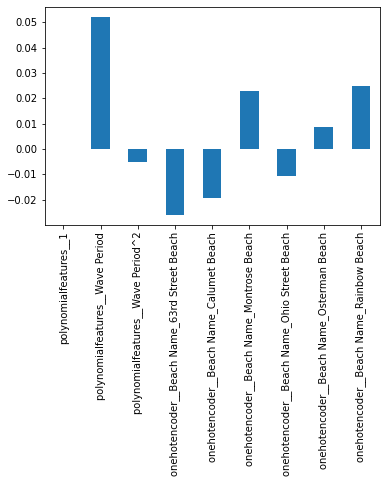

In [21]:
s = pd.Series(m4["lr"].coef_, index=m4["transformers"].get_feature_names_out())
s.plot.bar()

<AxesSubplot:>

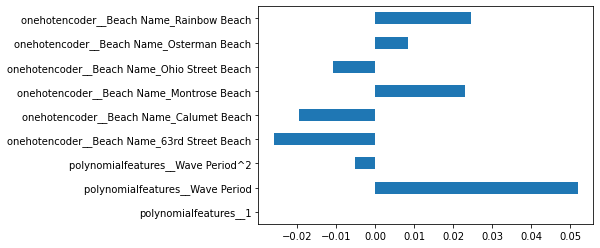

In [22]:
# Bar horizontal plot will be slightly better in terms of readability
s.plot.barh()

What are the beaches that have the biggest waves?

# Linear Algebra

- Installation requirements: `pip3 install rasterio Pillow`

### Where do numpy arrays show up in ML?

- A `DataFrame` is just a matrix wihout column names or row indices

In [23]:
df = pd.DataFrame([[0, 2, 1], [2, 3, 4], [8, 5, 6]], columns=["x1", "x2", "y"])
df

,x1,x2,y
0,0,2,1
1,2,3,4
2,8,5,6


`df.values` gives us a `numpy.ndarray` of all the values.
`nd` stands for n-dimensional:
- 2-dimensional for matrix
- 1-dimensional for vector

In [24]:
print(type(df.values))
df.values

<class 'numpy.ndarray'>


array([[0, 2, 1],
       [2, 3, 4],
       [8, 5, 6]])

In [25]:
model = LinearRegression()
model.fit(df[["x1", "x2"]], df["y"])
model.coef_

array([-2.,  7.])

In [26]:
model.predict(df[["x1", "x2"]])

array([1., 4., 6.])

#### How does `predict` actually work?

- Matrix multiplication with coefficients (`@`) and add intercept

In [27]:
df[["x1", "x2"]].values @ model.coef_ + model.intercept_

array([1., 4., 6.])

### How to create numpy arrays from scratch?

- requires `import numpy as np`
    - `np.array(<object>)`: creates numpy array from object instance; documentation: https://numpy.org/doc/stable/reference/generated/numpy.array.html
    - `np.ones(<shape>)`: creates an array of ones; documentation: https://numpy.org/doc/stable/reference/generated/numpy.ones.html
    - `np.zeros(<shape>)`: creates an array of zeros; documentation: https://numpy.org/doc/stable/reference/generated/numpy.zeros.html

In [28]:
np.array([7, 8, 9])

array([7, 8, 9])

In [29]:
np.ones(8)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
np.zeros(8)

array([0., 0., 0., 0., 0., 0., 0., 0.])

#### Review: `range()`

In [31]:
# 0 to exclusive end
# range(END)
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [32]:
# inclusive start to exclusive end
# range(START, END)
list(range(-4, 10))

[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
# inclusive start to exclusive end with a step between values
# default STEP is 1
# range(START, END, STEP)
list(range(-4, 10, 2))

[-4, -2, 0, 2, 4, 6, 8]

In [34]:
# range cannot have floats for the STEP
list(range(-4, 10, 0.5))

TypeError: 'float' object cannot be interpreted as an integer

#### Back to `numpy`
- `np.arange([start, ]stop, [step, ])`: gives us an array based on range; documentation: https://numpy.org/doc/stable/reference/generated/numpy.arange.html

In [35]:
# array range
np.arange(-4, 10, 0.5)   

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
        1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,
        7. ,  7.5,  8. ,  8.5,  9. ,  9.5])

#### Review: Slicing

- `seq_object[<START>:<exclusive_END>:<STEP>]`
    - `<START>` is optional; default is index 0
    - `<END>` is optional; default is `len` of the sequence
- slicing creates a brand new object instance

In [36]:
# REVIEW: Python slicing of lists
a = [7, 8, 9, 10]
# slice out 8 and 10
b = a[1::2] 
b

[8, 10]

In [37]:
b[1] = 100
b

[8, 100]

In [38]:
# original object instance doesn't change
a

[7, 8, 9, 10]

Slicing is slow because of creating a new object instance.

#### How to slice `numpy` arrays? 
- Unlike regular slicing `numpy` slicing is very efficient - doesn't do a copy

In [39]:
a = np.array([7, 8, 9, 10])
# slice out 8 and 10
b = a[1::2]  
b

array([ 8, 10])

In [40]:
b[1] = 100
a

array([  7,   8,   9, 100])

How can you ensure that changes to a slice don't affect original `numpy.array`? Use `copy` method.

In [41]:
a = np.array([7, 8, 9, 10])
b = a.copy() # copy everything instead of sharing
b = a[1::2] 
b[1] = 100
b, a

(array([  8, 100]), array([  7,   8,   9, 100]))

#### Creating Multi-Dimensional Arrays

- using nested data structures like list of lists
- `shape` gives us the dimension of the `numpy.array`
- `len()` gives the first dimension, that is `shape[0]`

In [42]:
a = np.array([1, 2, 3])
a, len(a)

(array([1, 2, 3]), 3)

How many numbers are there in the below `tuple`?

In [43]:
a.shape

(3,)

One number in this `tuple`, and it is 3.

In [44]:
# 2-D array using list of lists
b = np.array([[1, 2, 3], [4, 5, 6]])
b

array([[1, 2, 3],
       [4, 5, 6]])

In [45]:
b.shape

(2, 3)

2 dimensional (because two numbers are there in this `tuple`). sizes 2 and 3 along those dimensions.

In [46]:
len(b)

2

#### How to reshape a `numpy.array`?

- `<obj>.reshape(<newshape>)`: reshapes the dimension of the array; documentation: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

In [47]:
b

array([[1, 2, 3],
       [4, 5, 6]])

In [48]:
b.reshape(3, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [49]:
b.reshape(6)

array([1, 2, 3, 4, 5, 6])

We cannot add/remove values while reshaping.

In [51]:
b.reshape(5)

ValueError: cannot reshape array of size 6 into shape (5,)

In [52]:
b.reshape(7)

ValueError: cannot reshape array of size 6 into shape (7,)

-1 means whatever size is the necessary shape for the remaining values. Enables us to just control one of the dimensions.

In [53]:
b.reshape(3, -1)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [54]:
b.reshape(-1)

array([1, 2, 3, 4, 5, 6])

Generate a 10*10 with numbers from 0 to 99.

In [55]:
np.arange(100).reshape(10, -1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

### Vocabulary
- scalar: 0 dimensional array
- vector: 1 dimensional array
- matrix: 2 dimensional array
- tensor: n dimensional (0, 1, 2, 3, ...) array 

### Images as Tensors

- `wget` command:
    - `wget <url> -O <local file name>`

In [56]:
# Only run this cell once
!wget "https://upload.wikimedia.org/wikipedia/commons/f/f2/Coccinella_magnifica01.jpg" -O bug.jpg

--2023-04-14 05:40:33--  https://upload.wikimedia.org/wikipedia/commons/f/f2/Coccinella_magnifica01.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2391153 (2.3M) [image/jpeg]
Saving to: ‘bug.jpg’

bug.jpg             100%[===================>]   2.28M  11.8MB/s    in 0.2s    

2023-04-14 05:40:34 (11.8 MB/s) - ‘bug.jpg’ saved [2391153/2391153]



#### How to read an image file?

- required `import matplotlib.pyplot as plt`
    - `plt.imread(<fname>)`: reads an image file into a 3-dimensional array --- rows(pixels), columns(pixels), colors (red/green/blue)
    - `plt.imshow(<array>, cmap=<color map>)`: displays the image

In [57]:
a = plt.imread("bug.jpg")
type(a)

numpy.ndarray

In [58]:
# 3-dimensional array
# rows(pixels), columns(pixels), colors (red/green/blue)
a.shape

(1688, 2521, 3)

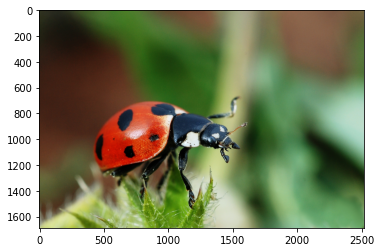

In [59]:
plt.imshow(a)

In [60]:
a 
# each inner array has 3-color representation R, G, B
# two color scales: floats (0.0 to 1.0) OR ints (0 to 255)

array([[[ 47,  52,  32],
        [ 41,  46,  26],
        [ 46,  49,  30],
        ...,
        [108,  95,  60],
        [111,  98,  63],
        [117, 104,  69]],

       [[ 43,  48,  28],
        [ 40,  45,  25],
        [ 44,  47,  28],
        ...,
        [112,  99,  64],
        [115, 102,  67],
        [114, 101,  66]],

       [[ 41,  46,  26],
        [ 42,  47,  27],
        [ 43,  46,  27],
        ...,
        [116, 103,  68],
        [114, 101,  66],
        [112,  97,  64]],

       ...,

       [[187, 193, 147],
        [189, 195, 149],
        [192, 198, 150],
        ...,
        [ 93, 131,  58],
        [ 92, 130,  55],
        [ 92, 130,  53]],

       [[190, 196, 150],
        [191, 197, 151],
        [192, 198, 150],
        ...,
        [ 94, 132,  57],
        [ 94, 130,  56],
        [ 91, 128,  51]],

       [[192, 198, 152],
        [191, 197, 151],
        [190, 196, 148],
        ...,
        [ 95, 131,  57],
        [ 93, 129,  55],
        [ 93, 130,  53]]

#### GOAL: crop down just to the bug using slicing

- `<array>[ROW SLICE, COLUMN SLICE, COLOR SLICE]`

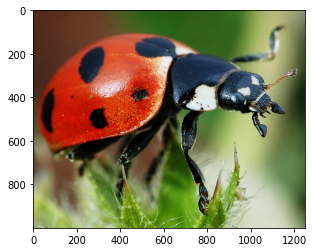

In [61]:
plt.imshow(a[600:1600, 400:1650, :])

#### GOAL: show clearly where RED is high on the image
- two formats:
    - 3D (row, column, color)
    - 2D (row, column) => black/white (red/blue)

In [62]:
a.shape

(1688, 2521, 3)

Pull out only layer 0, which is the red layer.
- 0 is red
- 1 is green
- 2 is blue

Use index only for the color dimension and slices for row and column dimensions

In [63]:
a[:, :, 0].shape 

(1688, 2521)

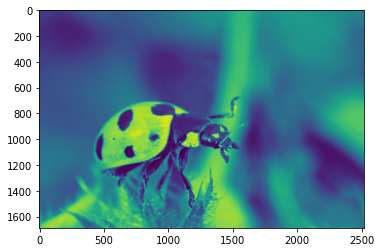

In [64]:
# instead of using black and white, 
# it is just assigning some color for light and dark
plt.imshow(a[:, :, 0])

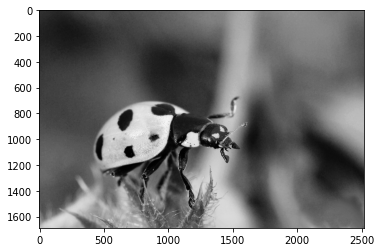

In [65]:
# better to use grayscale
plt.imshow(a[:, :, 0], cmap="gray")

Wherever there was red, the image is bright. The bug is very bright because of that. There are other places in the image that are bright but were not red. This is because when we mix RGB, we get white. Any color that was light will also have a lot of RED.

This could be a pre-processing step for some ML algorithm that can identify RED bugs. 

#### GOAL: show a grayscale that considers the average of all colors

- `<array>.mean(axis=<val>)`:
    - `axis` should be 0 for 1st dimension, 1 for 2nd dimension, 2 for 3rd dimension

In [66]:
# average over all the numbers
# gives a measure of how bright the image is overall
a.mean()

91.74619781513016

In [67]:
a.shape

(1688, 2521, 3)

In [68]:
# average over each column and color combination
a.mean(axis=0).shape

(2521, 3)

In [69]:
# average over each row and color combination
a.mean(axis=1).shape

(1688, 3)

In [70]:
# average over each row and column combination
a.mean(axis=2).shape

(1688, 2521)

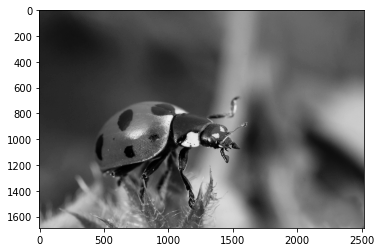

In [71]:
plt.imshow(a.mean(axis=2), cmap="gray")

This could also be a pre-processing step for some ML algorithm that expects black and white images.

### Vector Multiplication: Overview

#### Elementwise Multiplication

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
*
\begin{bmatrix}
4 \\ 5 \\ 6
\end{bmatrix}$

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
*
\begin{bmatrix}
4 & 5 & 6
\end{bmatrix}$

### Dot Product

$\begin{bmatrix}
1 & 2 & 3
\end{bmatrix}
\cdot
\begin{bmatrix}
4 \\ 5 \\ 6
\end{bmatrix}$

$\begin{bmatrix}
1 \\ 2 \\ 3
\end{bmatrix}
\cdot
\begin{bmatrix}
4 & 5 & 6
\end{bmatrix}$

In [72]:
v1 = np.array([1, 2, 3]).reshape(-1, 1) # vertical shape
v1

array([[1],
       [2],
       [3]])

In [73]:
v2 = np.array([4, 5, 6]).reshape(-1, 1)
v2

array([[4],
       [5],
       [6]])

Elementwise multiplication:

In [74]:
v1 * v2   # [1*4, 2*5, 3*6]

array([[ 4],
       [10],
       [18]])

#### Transpose

- flips the x and y

In [75]:
v2

array([[4],
       [5],
       [6]])

In [76]:
v2.T # horizontal

array([[4, 5, 6]])

In [77]:
v2.T.T # vertical

array([[4],
       [5],
       [6]])

In [78]:
v1.shape

(3, 1)

In [79]:
v2.T.shape

(1, 3)

In [80]:
v1 * v2.T # how is this working?

array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])